# Age and Education Level of 2017 Czech Parliament Election Candidates

Choose at least three parties that are going to participate in the election.
Scrap the web pages https://volby.cz to get list of all candidates for the chosen parties
(good place to start: https://volby.cz/pls/ps2017/ps11?xjazyk=CZ&xv=1&xt=1).

In [1]:
from collections import Counter
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def read_party_df(url):
    r = requests.get(url)
    dfs = pd.read_html(r.text, flavor='bs4', skiprows=2)
    column_names = {1: 'Kraj', 2: 'Number', 3: 'Name', 4: 'Age',
                    5: 'Party', 6: 'Political affiliation'}
    # first two rows are columns names
    # drop uninmportant columns
    # correct columns names
    return dfs[0].drop([0, 1])\
                 .drop([0, 7, 8], axis=1)\
                 .rename(index=lambda x: x - 2, columns=column_names)

In [4]:
urls = {
    'ANO': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=21&xv=1&xt=1',
    'DSSS': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=28&xv=1&xt=1',
    'KSČM': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=8&xv=1&xt=1',
    'Piráti': 'https://volby.cz/pls/ps2017/ps111?xjazyk=CZ&xkraj=0&xstrana=15&xv=1&xt=1',
}

df = pd.concat({party: read_party_df(url) for party, url in urls.items()})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1359 entries, (ANO, 0) to (Piráti, 335)
Data columns (total 6 columns):
Kraj                     1359 non-null object
Number                   1359 non-null int64
Name                     1359 non-null object
Age                      1359 non-null int64
Party                    1359 non-null object
Political affiliation    1359 non-null object
dtypes: int64(2), object(4)
memory usage: 70.4+ KB


In [6]:
df.head()

Kraj  Number                          Name  Age Party  \
ANO 0       Pardubický      14                 Akerman Miloš   61   ANO   
    1          Ústecký      22              Andrš Radek Ing.   48   ANO   
    2      Karlovarský      10  Arnoldová Lenka Mgr. et Mgr.   52   ANO   
    3     Jihomoravský      24     Artimová Zuzana Olga Ing.   53   ANO   
    4  Moravskoslezský      27            Babinec Radim Mgr.   43   ANO   

      Political affiliation  
ANO 0                   ANO  
    1                   ANO  
    2                   ANO  
    3                   ANO  
    4                   ANO

## 1. Use Data Visualisation to Depict the Age Distribution of Candidates
    
- How many candidates are young/old/middle aged?
- Which party has older candidates compared to the others?

In [7]:
df['Age'].groupby(level=0).describe()

,count,mean,std,min,25%,50%,75%,max
ANO,341.0,48.580645,10.252264,22.0,42.0,48.0,56.0,72.0
DSSS,341.0,44.422287,12.944587,21.0,34.0,44.0,53.0,74.0
KSČM,341.0,49.841642,12.639044,21.0,41.0,51.0,61.0,74.0
Piráti,336.0,37.157738,10.743778,21.0,30.0,34.0,43.0,71.0


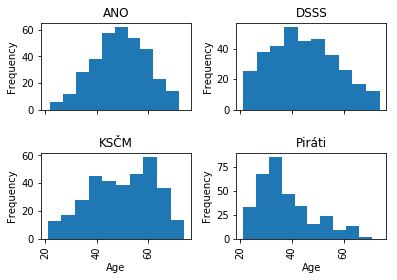

In [8]:
axes = df.hist(column='Age', by='Party', sharex=True)
for ax in axes.ravel():
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')

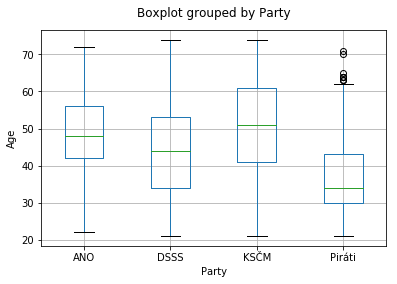

In [9]:
ax = df.boxplot(column='Age', by='Party')
ax.set_title('')
ax.set_ylabel('Age')

## 2. Use the Titles of Candidates to Get the Idea on Education Levels


Try to distinguish at least three education levels corresponding to:

- no title,
- Bc.,
- Ing., Mgr. and analogous and higher.
    
E.g. *Barteček Ivo prof. PhDr. CSc.* has three titles 'prof.', 'PhDr.' and 'CSc.'.

Your visualisation should answer at least these questions:

- How frequent are the education levels of candidates for each of the choosen parties?
- How *'educated'* is each party compared to the others?
- How frequent is each education level within all candidates?

In [10]:
splited_names = df['Name'].apply(lambda x: re.split(' |, +', x))
splited_names.head()

ANO  0                      [Akerman, Miloš]
     1                  [Andrš, Radek, Ing.]
     2    [Arnoldová, Lenka, Mgr., et, Mgr.]
     3        [Artimová, Zuzana, Olga, Ing.]
     4                [Babinec, Radim, Mgr.]
Name: Name, dtype: object

In [11]:
# split each name to list by whitespace
# flatten the list
# convert the list to set
counter = Counter([item for sublist in splited_names.tolist() for item in sublist])

# assume that title ends with '.' (e.g. Bc., Ing.) or
# is uppercase (e.g. MBA, BA)
degrees = {x for x in counter if x.endswith('.') or x.isupper()}
# let's make some assuptions
# do not care about 'ml.'
# if somebody is 'dr. h. c.' he or she either buy it or is master anyway
# 'DiS.' is considered as no degree, sorry
degrees -= {'ml.', 'Dr.h.c.', 'dr.', 'h.', 'c.', 'DiS.'}
# bachelor's degrees in this case start with 'B' or it's 'LL.B.'
bachelors = {degree for degree in degrees if degree.startswith('B')} | {'LL.B.'}
masters = degrees - bachelors
bachelors, masters

({'B.A.', 'BA', 'BBA', 'BSc.', 'Bc.', 'LL.B.'},
 {'CSc.',
  'DBA',
  'Dr.',
  'Ing.',
  'JUDr.',
  'LL.M.',
  'MBA',
  'MPA',
  'MUDr.',
  'MVDr.',
  'MgA.',
  'Mgr.',
  'PaedDr.',
  'Ph.D.',
  'PhDr.',
  'RNDr.',
  'RSDr.',
  'arch.',
  'doc.',
  'prof.'})

In [12]:
def classify_titles(xs):
    # TODO try sets intersection
    xs = set(xs)
    if not masters.isdisjoint(xs):
        return 'Master'
    if not bachelors.isdisjoint(xs):
        return 'Bachelor'
    return 'No title'

df['Education'] = splited_names.apply(classify_titles)
df.tail()

Kraj  Number                     Name  Age   Party  \
Piráti 331         Vysočina       8         Závrská Kateřina   33  Piráti   
       332        Olomoucký      10            Zmeškal Miloš   30  Piráti   
       333      Středočeský       6         Zmuda Tomáš Ing.   29  Piráti   
       334  Moravskoslezský      26        Žebrok Marcel Bc.   32  Piráti   
       335  Moravskoslezský      35  Žídek Arnošt Mgr. Ph.D.   41  Piráti   

           Political affiliation Education  
Piráti 331                Piráti  No title  
       332                Piráti  No title  
       333                Piráti    Master  
       334                Piráti  Bachelor  
       335                 BEZPP    Master

In [13]:
edu_counts = df['Education'].groupby(level=0)\
                            .value_counts()\
                            .unstack(level=1)
edu_percent = edu_counts.div(edu_counts.sum(axis=1), axis=0)\
                        .multiply(100)[['No title', 'Bachelor', 'Master']]

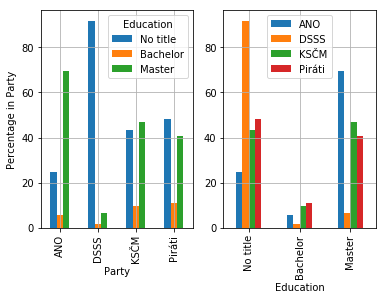

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
edu_percent.plot.bar(ax=ax1, grid=True)
edu_percent.T.plot.bar(ax=ax2, grid=True)
ax1.set_xlabel('Party')
ax1.set_ylabel('Percentage in Party')

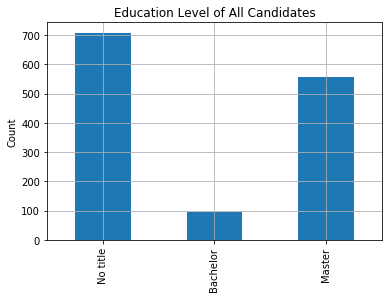

In [15]:
axes = df['Education'].value_counts()[['No title', 'Bachelor', 'Master']].plot(kind='bar', grid=True)
axes.set_title('Education Level of All Candidates')
axes.set_ylabel('Count')